# Gaussian Proccess (GP) on M1 and S2 Site Data
We wish to determine the seasonal and diurnal cycles of supermicron aerosols/bioaerosols. In this notebook we focus on the seasonal trends. We will split the data up by seasons and fit a GP on a subset of the data. Using a confidence interval, we will determine if the data indicates seasonal cycles. 

In [230]:
import pandas as pd
import os

os.environ["OMP_NUM_THREADS"] = "2"



def data_import(path1, delimiter):
    #locate file path and import data
    if delimiter == 'none':
        file1 = pd.read_csv(path1)
    else:   
        file1 = pd.read_csv(path1, delimiter=delimiter)
    return file1

def data_convert(file1, time_column_name: str):
    #convert timestamps to datetime format
    file1[time_column_name] = pd.to_datetime(file1[time_column_name])
   
    #handle missing values (NaN); fill with mean value
    file1.fillna(file1.mean(), inplace=True)

    return file1

def data_frequency(file1, desired_frequency: str, time_column_name: str):
    if desired_frequency == 'ten_minute':
        file1 = file1.resample('10T', on=time_column_name).mean()
    elif desired_frequency == 'hourly':
        file1 = file1.resample('h', on=time_column_name).mean()
    elif desired_frequency == 'daily':
        file1 = file1.resample('D', on=time_column_name).mean()

    # Reset the index and rename it back to 'Time(UTC)'
    file1.reset_index(inplace=True)
    file1.rename(columns={'index': 'Time(UTC)'}, inplace=True)

    return file1

def time_to_sincos(df):
    sin_values = []
    cos_values = []

    for i in range(len(df)):
        sin_values.append(np.sin((2 * np.pi * i) / 365.25))
        cos_values.append(np.cos((2 * np.pi * i) / 365.25))
        
    df['Time_sin'] = sin_values
    df['Time_cos'] = cos_values
    
    return df

#trim data to desired collumns
def file_trim(file1, desired_collumns):
    file1 = file1[desired_collumns]
    return file1

#separate data by seasons
def data_split(file1, time_column_name: str):
    winter = file1[(file1[time_column_name] >= '2022-12-21') & (file1[time_column_name] < '2023-03-20')]
    spring = file1[(file1[time_column_name] >= '2023-03-20') & (file1[time_column_name] < '2023-06-21')]
    summer = file1[(file1[time_column_name] >= '2022-06-21') & (file1[time_column_name] < '2022-09-23')]
    autunm = file1[(file1[time_column_name] >= '2022-09-23') & (file1[time_column_name] < '2022-12-21')]
    return winter, spring, summer, autunm





In [231]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from kneed import KneeLocator
import warnings
from sklearn.decomposition import PCA


# function to reduce dimensionality 
def pca(data):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    principalDf_headers = list(principalDf.columns)
    return principalDf, principalDf_headers

def elbow_plot(data, title, features):
    distortions = []
    K = range(1, 15)
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data[features])
        distortions.append(kmeans.inertia_)  # Distortion (inertia) for each k

    # Use KneeLocator to find the optimal k
    kneedle = KneeLocator(K, distortions, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow

    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title(title)  # Use the title argument here
    plt.grid(True)

    # Highlight the optimal k
    if optimal_k is not None:
        plt.axvline(x=optimal_k, color='r', linestyle='--')
        plt.scatter(optimal_k, distortions[optimal_k-1], color='red', s=100, zorder=5)
        plt.text(optimal_k, distortions[optimal_k-1], f'  k={optimal_k}', fontsize=12, color='red', verticalalignment='bottom')

    return optimal_k    



# Function to generate inducing points
def k_means(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    inducing_points = kmeans.cluster_centers_
    return inducing_points

def k_means_sillohette(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters).fit(data)
    labels = kmeans.labels_
    sil_score = silhouette_score(data, labels)
    return sil_score    

def inducing_points(data, n_clusters):
    inducing_points = k_means(data, n_clusters)
    return inducing_points
  

In [232]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.special import kv, gamma

def matern_kernel(x, x_star, length_scale=200, nu=5/2, variance = 1.4):

    dists = cdist(x / length_scale, x_star / length_scale, metric='euclidean')
    
    if nu == 0.5:
        K = np.exp(-dists)

    elif nu == 1.5:
        sqrt3 = np.sqrt(3)
        K = (1.0 + sqrt3 * dists) * np.exp(-sqrt3 * dists)

    elif nu == 2.5:
        sqrt5 = np.sqrt(5)
        K = (1.0 + sqrt5 * dists + (5.0 / 3.0) * (dists ** 2)) * np.exp(-sqrt5 * dists)

    else:
        K = (2 ** (1.0 - nu)) / gamma(nu) * (np.sqrt(2 * nu) * dists) ** nu * kv(nu, np.sqrt(2 * nu) * dists)
        K[dists == 0.0] = 1.0  # Handle the case when dists is zero

    return variance * K

def gram_matrix(X1, X2, covar_func1 = matern_kernel):
    return covar_func1(X1, X2)

def run_gp_regression(x, x_star, y_target, noise = 0.0):

    #compute the covariance (gram) matrix
    K = (gram_matrix(x, x)) + (noise ** 2) * np.eye(len(x))
    K_star = gram_matrix(x, x_star)
    K_star_star = gram_matrix(x_star, x_star)

    
    L = np.linalg.cholesky(K)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_target))
    f_mean_star = np.dot(K_star.T, alpha)
    v = np.linalg.solve(L, K_star)
    f_var_star = K_star_star - np.dot(v.T, v)
    
    return f_mean_star, f_var_star

# S2 site data importing and modeling 

In [233]:
#collumns, features and target
collumns = ['Time(UTC)', 'sample_rh_pct', 'sample_temp_C', 'pm_1_ug_per_m3', 'Time_sin', 'Time_cos']
features = ['sample_rh_pct', 'sample_temp_C', 'pm_1_ug_per_m3', 'Time_sin', 'Time_cos']
s2_target_pm1 = ['pm_1_ug_per_m3']
s2_target_pm25 = ['pm_25_ug_per_m3']
s2_target_pm10 = ['pm_10_ug_per_m3']

# importing data, hourly frequency
s2_site_data = data_import("C:\\Users\\396760\\lanl\\data\\ARMSAILS2_cleaned.csv", 'none')
s2_site_data = data_convert(s2_site_data, 'Time(UTC)')
s2_site_data = data_frequency(s2_site_data, 'hourly', 'Time(UTC)')
s2_site_data = time_to_sincos(s2_site_data)
s2_site_data = file_trim(s2_site_data, collumns)

#split data by seasons
s2_winter, s2_spring, s2_summer, s2_autunm = data_split(s2_site_data, 'Time(UTC)')
s2_winter = s2_winter.drop(columns=['Time(UTC)'])
s2_spring = s2_spring.drop(columns=['Time(UTC)'])
s2_summer = s2_summer.drop(columns=['Time(UTC)'])
s2_autunm = s2_autunm.drop(columns=['Time(UTC)'])



[[-27.51945835  -4.91264936]
 [ 17.45668947  -4.77997916]
 [ -5.30179331  -1.88282787]
 [ 13.64139881  12.88611092]
 [-11.67115831  35.70354922]]


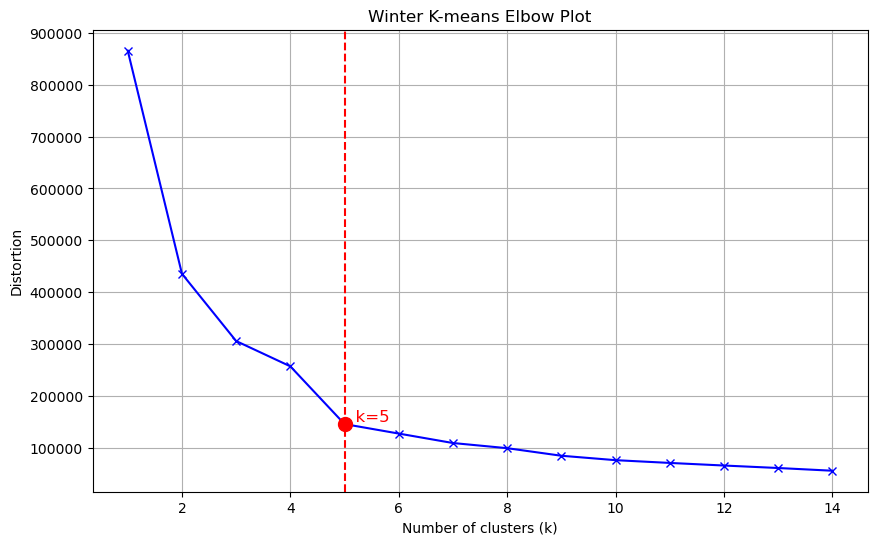

In [235]:
def test():
    # %%
    import matplotlib.pyplot as plt

    # Run GP regression
    f_mean_star, f_var_star = run_gp_regression(winter_x, winter_x_star, winter_target, noise=0.1)

    # Convert dates for x-axis
    winter_dates = winterM1['Date'].unique()
    winter_dates_star = pd.date_range(start='2022-12-21', end='2023-03-20', periods=len(winter_x_star))

    # Extract true aerosol data
    winter_aerosol = daily_winterM1[targetPM1].values

    # Compute the confidence interval
    confidence_interval = (1.96 * np.sqrt(np.diag(f_var_star))) # 95% confidence interval

    # Ensure the shapes are consistent
    f_mean_star = f_mean_star.flatten()

    # Plot true data points
    plt.figure(figsize=(14, 8))
    plt.plot(winter_dates, winter_aerosol, 'ro-', label='True Aerosol Data')

    # Plot predicted data points
    plt.plot(winter_dates_star, f_mean_star, 'bo-', label='Predicted Aerosol Data')

    # Plot the confidence interval
    confidence_interval_1 = f_mean_star - confidence_interval
    confidence_interval_2 = f_mean_star + confidence_interval

    for i in range(len(confidence_interval_1)):
        if confidence_interval_1[i] < 0:
            confidence_interval_1[i] = 0

    for i in range(len(confidence_interval_2)):
        if confidence_interval_2[i] < 0:
            confidence_interval_2[i] = 0

    plt.fill_between(winter_dates_star, confidence_interval_1, confidence_interval_2,
                    color='lightblue', alpha=0.5, label='95% Confidence Interval')

    # Add labels and legend
    plt.xlabel('Time (December 21 to March 20)')
    plt.ylabel('Aerosol Output (ug/m3)')
    plt.title('Winter Aerosol Data Time Series with Predictions and Confidence Interval')
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()
